In [1]:
import tensorflow as tf
import cv2
import pandas as pd
import os

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
if(physical_devices):
    detales = tf.config.experimental.get_device_details(physical_devices[0])
    print(f"Код GPU: {physical_devices[0].name}")
    print(f"Имя GPU: {detales['device_name']}")

Код GPU: /physical_device:GPU:0
Имя GPU: NVIDIA GeForce RTX 3050 Laptop GPU


***

### Загрузка данных

In [3]:
data_path = '../data/Rice_Image_Dataset'

paths = pd.Series([], name= 'path')
labels = pd.Series([],name = 'label')


for class_name in os.listdir(data_path):
    img_batch_path = os.path.join(data_path , class_name)
    
    if not os.path.isdir(img_batch_path):
        continue

    for img_name in os.listdir(img_batch_path):
        img_path = os.path.join(img_batch_path , img_name)
        paths.at[len(paths)] = img_path
        labels.at[len(labels)] = class_name

df = pd.concat([paths , labels] , axis = 1)

In [4]:
df.head()

,path,label
0,../data/Rice_Image_Dataset\Arborio\Arborio (1)...,Arborio
1,../data/Rice_Image_Dataset\Arborio\Arborio (10...,Arborio
2,../data/Rice_Image_Dataset\Arborio\Arborio (10...,Arborio
3,../data/Rice_Image_Dataset\Arborio\Arborio (10...,Arborio
4,../data/Rice_Image_Dataset\Arborio\Arborio (10...,Arborio


In [5]:
df['label'].unique()

array(['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],
      dtype=object)

***

### Создание датасета

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

In [9]:
train_ratio = 0.7

train, dummy = train_test_split(df, train_size=train_ratio , random_state=1242, shuffle=True)
validation, test = train_test_split(dummy , test_size=0.5 , random_state = 1242 , shuffle=True)

print(f"Обучающие данные: \t{train.shape[0]} изображений\nВалидационные данные: \t{validation.shape[0]} изображений\nТестовые данные: \t{test.shape[0]} изображений")

Обучающие данные: 	52500 изображений
Валидационные данные: 	11250 изображений
Тестовые данные: 	11250 изображений


In [10]:
target_img_size = (128, 128)
num_channels = 3
num_batches= 64

tr_gen= ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_set = tr_gen.flow_from_dataframe(train, 
                                       x_col = 'path', 
                                       y_col = 'label',
                                       target_size =target_img_size, 
                                       class_mode = 'categorical',
                                       color_mode = 'rgb', 
                                       shuffle = True, 
                                       batch_size = num_batches)

valid_set = ts_gen.flow_from_dataframe(validation, 
                                       x_col = 'path', 
                                       y_col = 'label',
                                       target_size = target_img_size, 
                                       class_mode = 'categorical',
                                       color_mode = 'rgb', 
                                       shuffle = True, 
                                       batch_size = num_batches)

test_set = ts_gen.flow_from_dataframe(test, 
                                      x_col = 'path', 
                                      y_col = 'label', 
                                      target_size = target_img_size, 
                                      class_mode = 'categorical',
                                      color_mode = 'rgb', 
                                      shuffle = False , 
                                      batch_size = num_batches)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


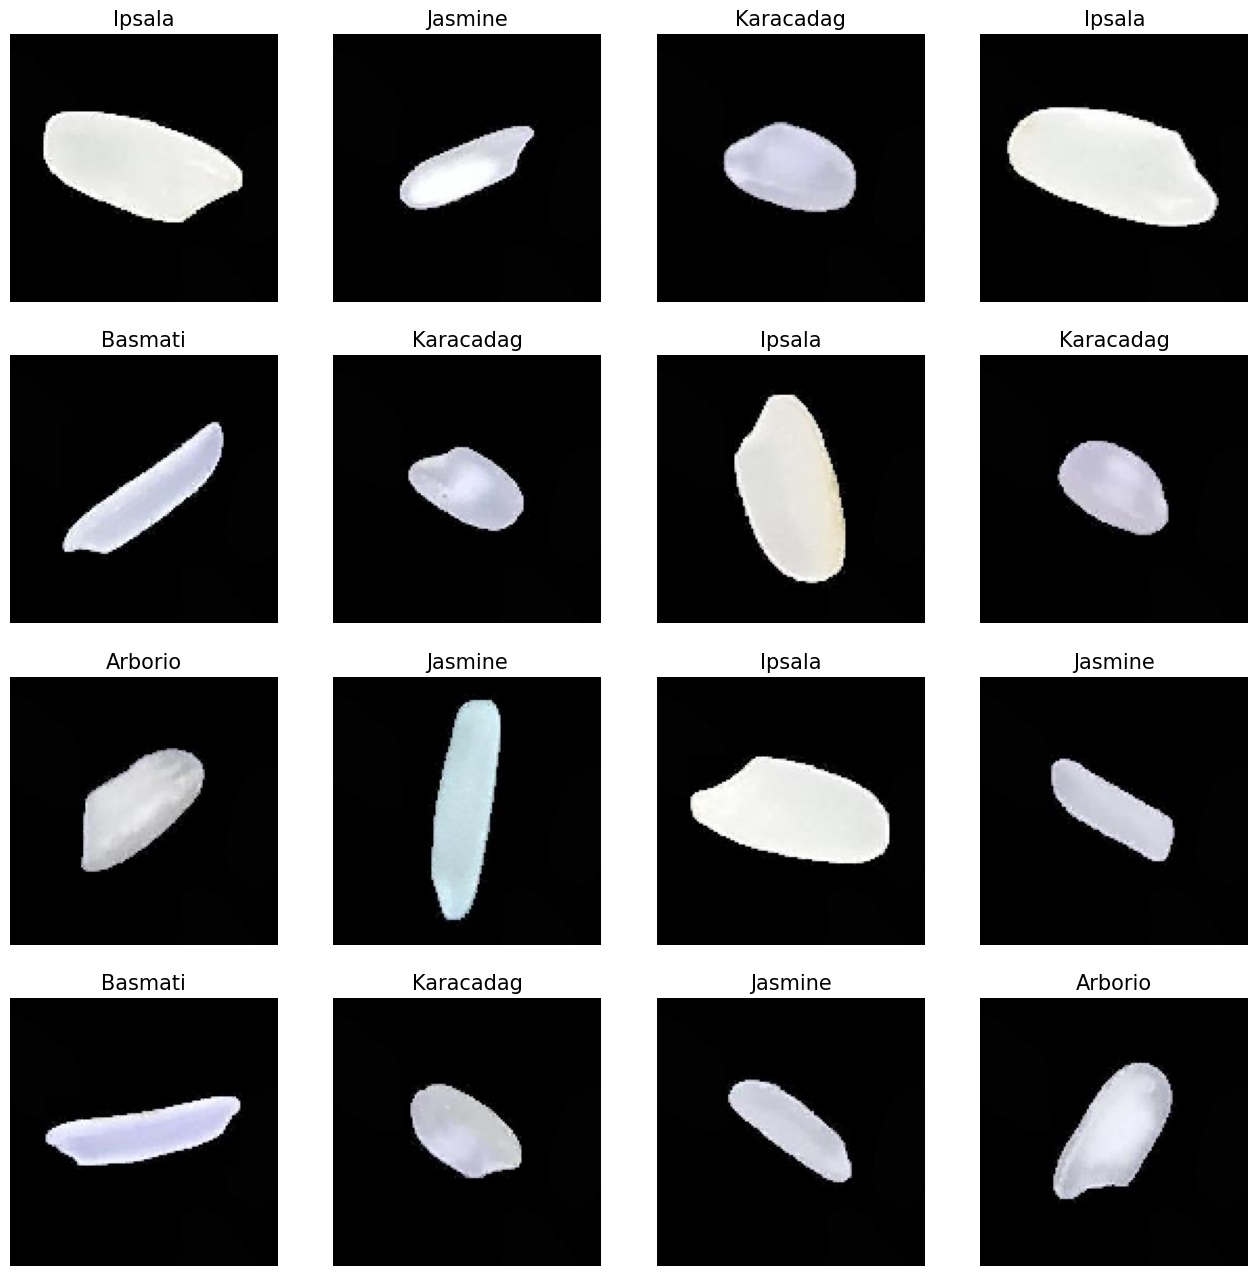

In [18]:
classes = list(train_set.class_indices.keys())
batch, labels = next(train_set)

plt.figure(figsize=(16,16))

for i in range(16):
    plt.subplot(4,4 , i+1)
    image = batch[i] / 255
    plt.imshow(image)
    plt.title(classes[np.argmax(labels[i])], fontsize=15)
    plt.axis('off')

***

### Модель и обучение 

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [23]:
num_classes = len(df['label'].unique())

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top = False, 
                                                               weights = 'imagenet',
                                                               input_shape = (target_img_size[0] , target_img_size[1] , num_channels),
                                                               pooling = 'max')

# Запрещаем изменение предобученых весов
base_model.trainable= False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dropout(rate= 0.2 , seed=333),
    Dense(num_classes, activation='softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 29,047,548
Trainable params: 529,925
Non-trainable params: 28,517,623
____________________________________

In [41]:
checkpoint_path = "./checkpoints/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

num_epochs= 10
with tf.device("/gpu:0"):
    history = model.fit(x = train_set,
                    validation_data = valid_set, 
                    epochs = num_epochs, 
                    verbose = True, 
                    validation_steps = None, 
                    shuffle = False,
                    callbacks = [cp_callback])

Epoch 1/10
821/821 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9735
Epoch 1: saving model to ./checkpoints\cp.ckpt
821/821 [==============================] - 219s 266ms/step - loss: 0.0830 - accuracy: 0.9735 - val_loss: 0.0353 - val_accuracy: 0.9870
Epoch 2/10
821/821 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9762
Epoch 2: saving model to ./checkpoints\cp.ckpt
821/821 [==============================] - 164s 200ms/step - loss: 0.0716 - accuracy: 0.9762 - val_loss: 0.0417 - val_accuracy: 0.9865
Epoch 3/10
821/821 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9763
Epoch 3: saving model to ./checkpoints\cp.ckpt
821/821 [==============================] - 164s 200ms/step - loss: 0.0707 - accuracy: 0.9763 - val_loss: 0.0369 - val_accuracy: 0.9871
Epoch 4/10
821/821 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.9790
Epoch 4: saving model to ./checkpoints\cp.ckpt
821/821 [==============

In [55]:
def draw_perfomance_plot(history):
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']

    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    index_acc = np.argmax(val_acc)

    val_lowest = val_loss[index_loss]
    val_highest = val_acc[index_acc]

    epochs= [i+1 for i in range(len(train_acc))]
    acc_label = f"Лучшая эпоха: {str(index_acc+1)}"
    loss_label = f"Лучшая эпоха: {str(index_loss+1)}"

    fig, axs = plt.subplots(1, 2, figsize= (20,8))

    axs[0].plot(epochs , train_acc , 'r' , label= "Training")
    axs[0].plot(epochs , val_acc , 'g' , label= "Validation")
    axs[0].scatter(index_acc +1 ,val_highest , s = 150 , c='blue', label=acc_label)
    axs[0].set_title('Accuracy')
    axs[0].set_xlabel("Эпоха")
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    axs[1].plot(epochs , train_loss , 'r' , label="Training")
    axs[1].plot(epochs , val_loss , 'g' , label="Validation")
    axs[1].scatter(index_loss +1 , val_lowest , s=150 , c='blue' , label=loss_label)
    axs[1].set_title("Loss")
    axs[1].set_xlabel("Эпоха")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    fig.tight_layout
    plt.show()

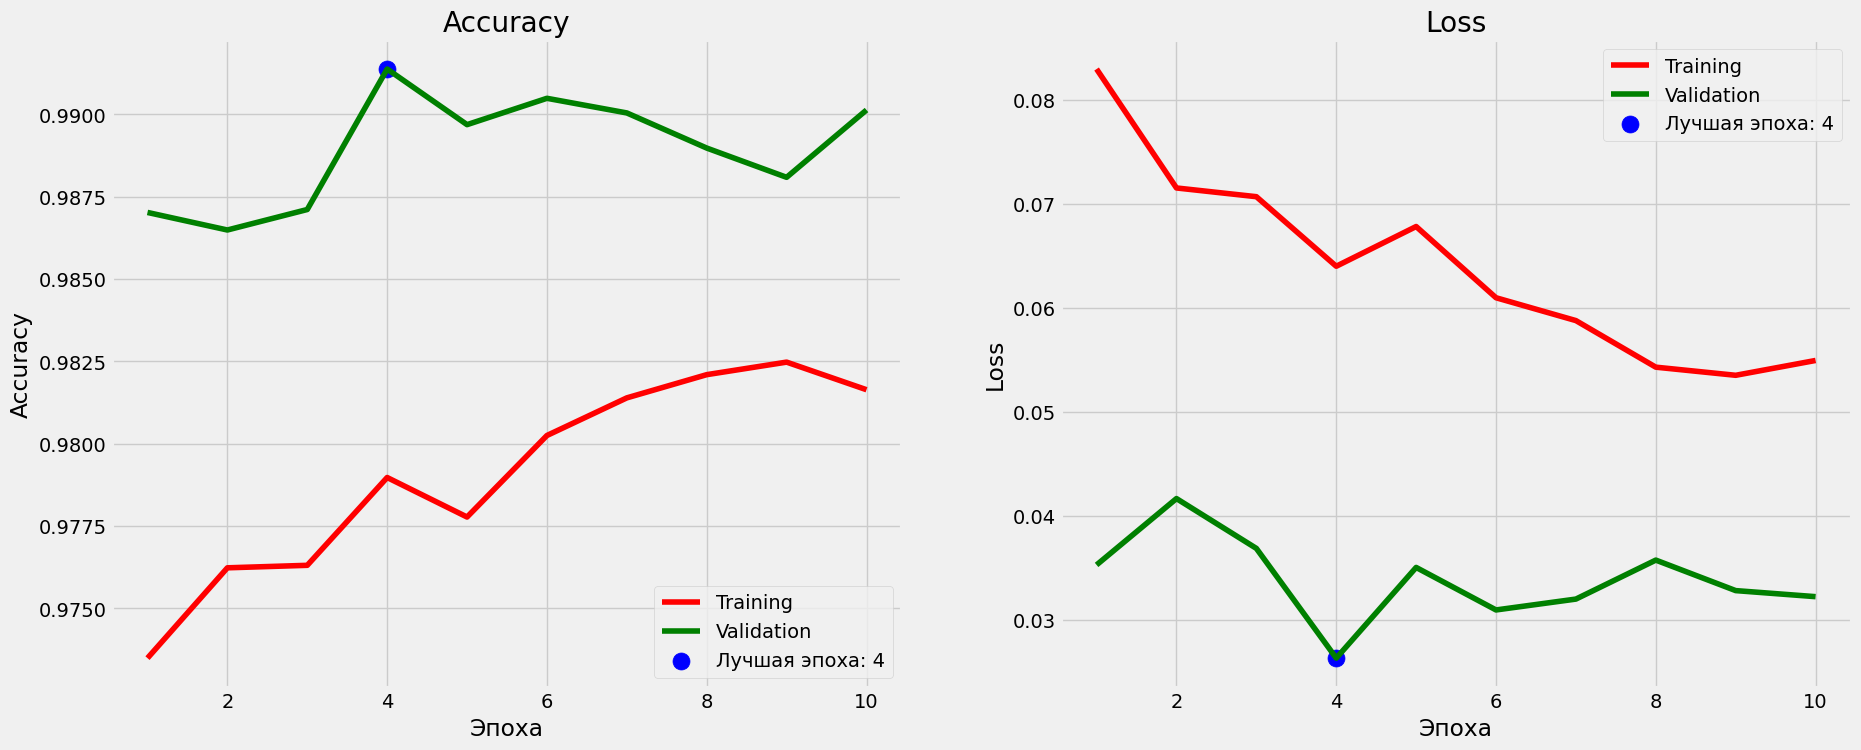

In [56]:
draw_perfomance_plot(history)

***

### Оценка модели

In [98]:
from sklearn.metrics import confusion_matrix, classification_report, r2_score

In [57]:
train_score = model.evaluate(train_set, steps=64, verbose=True)
valid_score = model.evaluate(valid_set, steps=64, verbose=True)
test_score = model.evaluate(test_set, steps=64, verbose=True)

64/64 [==============================] - 25s 396ms/step - loss: 0.0282 - accuracy: 0.9897


In [60]:
preds = model.predict(test_set)
y_pred = np.argmax(preds, axis=1)

176/176 [==============================] - 27s 156ms/step


Text(0.5, 30.051140985629516, 'Исходные классы')

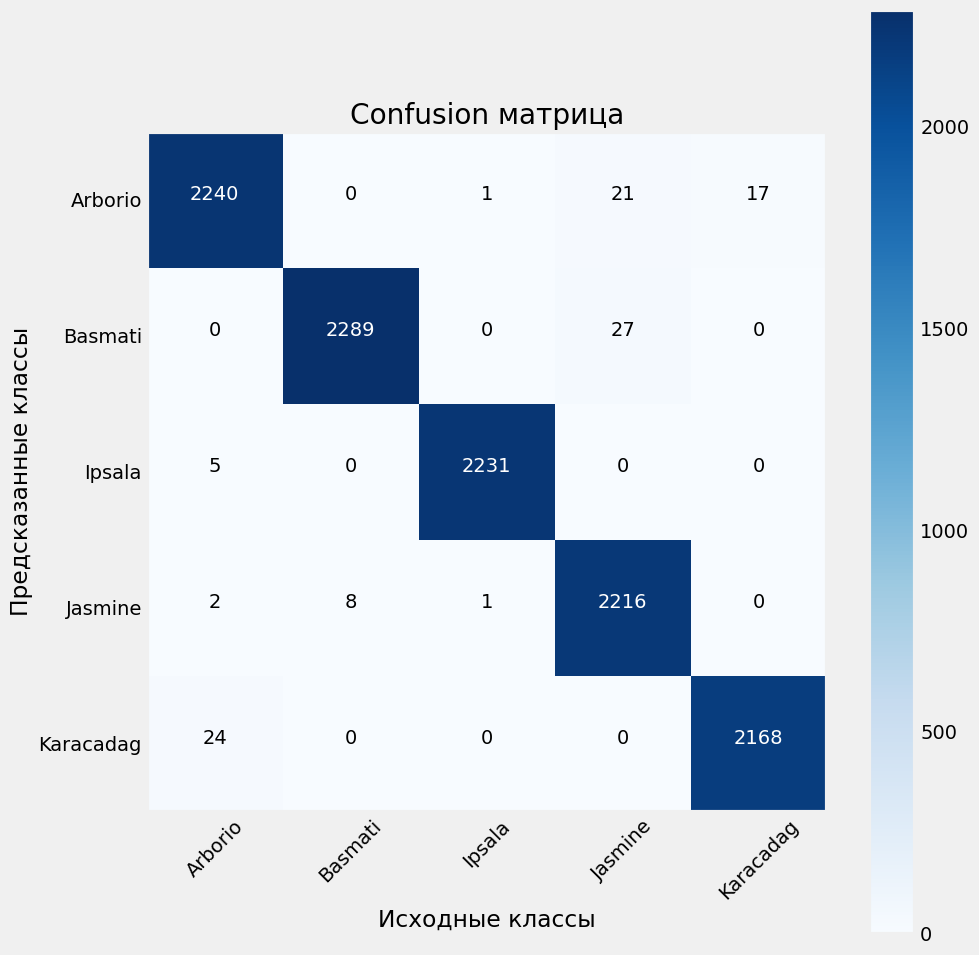

In [93]:
cm = confusion_matrix(test_set.classes, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
ax.set_title('Confusion матрица')
fig.colorbar(im, ax=ax)

ax.grid()


tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks, classes, rotation= 45)
ax.set_yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Предсказанные классы')
plt.xlabel('Исходные классы')

In [96]:
print(classification_report(test_set.classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

     Arborio       0.99      0.98      0.98      2279
     Basmati       1.00      0.99      0.99      2316
      Ipsala       1.00      1.00      1.00      2236
     Jasmine       0.98      1.00      0.99      2227
   Karacadag       0.99      0.99      0.99      2192

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250



In [105]:
r = r2_score(test_set.classes, y_pred)
print(f"R2 метрика: {r*100:.3f} %")

R2 метрика: 95.415 %
